<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#以有说话声数据作为训练，以噪声数据作为测试" data-toc-modified-id="以有说话声数据作为训练，以噪声数据作为测试-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>以有说话声数据作为训练，以噪声数据作为测试</a></span><ul class="toc-item"><li><span><a href="#导如所依赖的包和函数" data-toc-modified-id="导如所依赖的包和函数-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>导如所依赖的包和函数</a></span></li><li><span><a href="#提取特征的函数和归一化函数" data-toc-modified-id="提取特征的函数和归一化函数-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>提取特征的函数和归一化函数</a></span></li><li><span><a href="#提取用于训练数据的特征" data-toc-modified-id="提取用于训练数据的特征-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>提取用于训练数据的特征</a></span></li><li><span><a href="#加载用于训练的特征" data-toc-modified-id="加载用于训练的特征-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>加载用于训练的特征</a></span></li><li><span><a href="#定义模型及参数" data-toc-modified-id="定义模型及参数-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>定义模型及参数</a></span></li><li><span><a href="#训练模型" data-toc-modified-id="训练模型-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>训练模型</a></span></li><li><span><a href="#将训练数据送到模型中查看其对应的打分值（损失值，loss）" data-toc-modified-id="将训练数据送到模型中查看其对应的打分值（损失值，loss）-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>将训练数据送到模型中查看其对应的打分值（损失值，loss）</a></span></li><li><span><a href="#提取用于测试数据（噪声音频）的特征" data-toc-modified-id="提取用于测试数据（噪声音频）的特征-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>提取用于测试数据（噪声音频）的特征</a></span></li><li><span><a href="#将说话声（训练数据）的打分与噪声的打分花在直方图上进行对比" data-toc-modified-id="将说话声（训练数据）的打分与噪声的打分花在直方图上进行对比-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>将说话声（训练数据）的打分与噪声的打分花在直方图上进行对比</a></span></li><li><span><a href="#以FM的下的211个音频来测试（87-108）" data-toc-modified-id="以FM的下的211个音频来测试（87-108）-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>以FM的下的211个音频来测试（87-108）</a></span></li><li><span><a href="#加载模型的代码" data-toc-modified-id="加载模型的代码-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>加载模型的代码</a></span></li></ul></li><li><span><a href="#以噪声数据作为训练，以有说话声数据作为测试" data-toc-modified-id="以噪声数据作为训练，以有说话声数据作为测试-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>以噪声数据作为训练，以有说话声数据作为测试</a></span></li><li><span><a href="#用87到108的音频数据测试" data-toc-modified-id="用87到108的音频数据测试-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>用87到108的音频数据测试</a></span></li><li><span><a href="#一条音频一天音频地加载" data-toc-modified-id="一条音频一天音频地加载-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>一条音频一天音频地加载</a></span></li></ul></div>

# 以有说话声数据作为训练，以噪声数据作为测试


## 导如所依赖的包和函数

In [1]:
# encoding = utf-8
import numpy as np
import matplotlib.pyplot as plt
import random

import scipy.io.wavfile as wav
from python_speech_features import sigproc, mfcc, delta
from utility import *
from proj_paths import *
from settings import *

import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam, RMSprop

Using TensorFlow backend.


## 提取特征的函数和归一化函数

提取MFCC的最大最小均值方差，每一段音频的特征为156=（13×4+13×4+13×4）

In [2]:
def extract(sig):
    # framing
    sig_frames = sigproc.framesig(sig=sig, frame_len=FRAME_LENGTH, frame_step=FRAME_STEP)
    
    feat = []

    def calc_all_feat(feat_coeffs):
        feat.extend(feat_coeffs.max(axis=0))
        feat.extend(feat_coeffs.min(axis=0))
        feat.extend(feat_coeffs.mean(axis=0))
        feat.extend(feat_coeffs.var(axis=0))

    # region calculate mfcc features
    mfcc_feat = mfcc(signal=sig_frames, samplerate=SAMPLE_RATE, winlen=WINDOW_LENGTH, winstep=WINDOW_STEP,
                     numcep=13, preemph=PRE_EMPH, winfunc=WINDOW_FUNCTION)
    mfcc_feat_delta = delta(mfcc_feat, 20)
    mfcc_feat_delta_delta = delta(mfcc_feat_delta, 20)

    calc_all_feat(mfcc_feat)

    calc_all_feat(mfcc_feat_delta)

    calc_all_feat(mfcc_feat_delta_delta)

    # endregion

#     # region calculate zero cross rating
#     def zcr(frames):
#         def sign(x):
#             return 1 if x >= 0 else -1

#         zc_rates = []
#         for frame in frames:
#             zc_rate = 0
#             for i in range(1, len(frame)):
#                 zc_rate += abs(sign(frame[i]) - sign(frame[i - 1])) / 2
#             zc_rates.append(zc_rate / len(frame))
#         return zc_rates

#     zcrs = zcr(sig_frames)
#     calc_all_feat(np.array([zcrs]).reshape(len(zcrs), 1))
#     # endregion

#     # region calculate energy
#     def energy(frames, eta):
#         energys = []
#         for frame in frames:
#             energy = 1 / len(frame) * np.sum(np.power(frame, 2))
#             energys.append(energy)
#         return energys

#     energys = energy(sig_frames, 0)
#     calc_all_feat(np.array([energys]).reshape(len(energys), 1))
#     # endregion
    
    return feat

def normalize_frames(m, Scale=True):
    if Scale:
        return (m - np.mean(m, axis=0))/(np.std(m, axis=0)+2e-12)
    else:
        return (m - np.mean(m, axis=0))

## 提取用于训练数据的特征

In [21]:
import progressbar

bar = progressbar.ProgressBar(maxval=len(collect_files(SVM_DATA_SET_PATH)),
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
print("Extracting features ...")
features = []

for i, (raw_file_name, joined_file_path) in enumerate(collect_files(SVM_DATA_SET_PATH)):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    features.append(feats)
    bar.update(i + 1)

bar.finish()
print("Done.")

save(features, SVM_FEATURES_NAME, ".")

Extracting features ...


Done.


## 加载用于训练的特征

In [3]:
speech_fe = load('SPEECH_FEA')

# print(speech_fe)

print(np.array(speech_fe).shape)

speech_fe = np.array(speech_fe)

(357, 156)


## 定义模型及参数

In [4]:

encoding_dim = 256
decoding_dim = 156
input_img = Input(shape=(decoding_dim,))

# 编码层
encoded = Dense(encoding_dim, activation='relu')(input_img)
encoded = Dense(encoding_dim, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
encoder_output = Dense(encoding_dim)(encoded)

# 解码层
decoded = Dense(encoding_dim, activation='relu')(encoder_output)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(decoding_dim)(decoded)
# 构建自编码模型
autoencoder = Model(inputs=input_img, outputs=decoded)

# 构建编码模型
encoder = Model(inputs=input_img, outputs=encoder_output)

# compile autoencoder
# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.9, epsilon=1e-08, amsgrad=True)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 156)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               40192     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dens

## 训练模型

In [5]:
# training
autoencoder.fit(speech_fe, speech_fe, epochs=10, batch_size=10, shuffle=True)

filepath = 'autocode_0507.h5'
autoencoder.save(filepath)

# plotting
loss = autoencoder.evaluate(speech_fe, speech_fe, batch_size=1, verbose=2)
print('测试集损失函数值：', loss)
decoded_imgs = autoencoder.predict(speech_fe)
print(decoded_imgs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
357/357 [==============================] - 2s 6ms/step - loss: 0.1688
Epoch 2/10
357/357 [==============================] - 0s 311us/step - loss: 0.0413
Epoch 3/10
357/357 [==============================] - 0s 299us/step - loss: 0.0331
Epoch 4/10
357/357 [==============================] - 0s 316us/step - loss: 0.0278
Epoch 5/10
357/357 [==============================] - 0s 310us/step - loss: 0.0224
Epoch 6/10
357/357 [==============================] - 0s 300us/step - loss: 0.0184
Epoch 7/10
357/357 [==============================] - 0s 321us/step - loss: 0.0161
Epoch 8/10
357/357 [==============================] - 0s 331us/step - loss: 0.0146
Epoch 9/10
357/357 [==============================] - 0s 341us/step - loss: 0.0131
Epoch 10/10
357/357 [==============================] - 0s 338us/step - loss: 0.0126
测试集损失函数值： 0.012397332741756315
[[ 0.8745529   1.5768013   1.6528047  ... -0.3534099  -0.3447699
  -0.39646918]
 [ 0.4709797

---
## 将训练数据送到模型中查看其对应的打分值（损失值，loss）

In [6]:
from tqdm import tqdm

scores = []
for i in range(speech_fe.shape[0]):
    loss = autoencoder.evaluate(speech_fe[i:i+1], speech_fe[i:i+1], batch_size=1, verbose=0)
    scores.append(loss)
    print('loss', loss)

loss 0.011250472627580166
loss 0.012405707500874996
loss 0.009497568942606449
loss 0.005775017198175192
loss 0.007303138729184866
loss 0.008131570182740688
loss 0.01426883228123188
loss 0.018150903284549713
loss 0.012880404479801655
loss 0.009031862951815128
loss 0.016494201496243477
loss 0.013873482123017311
loss 0.012796388939023018
loss 0.007070775143802166
loss 0.021496759727597237
loss 0.0095903892070055
loss 0.010808412916958332
loss 0.015419021248817444
loss 0.010694991797208786
loss 0.012886466458439827
loss 0.014680342748761177
loss 0.011453090235590935
loss 0.009025149047374725
loss 0.02290952205657959
loss 0.011604385450482368
loss 0.008574520237743855
loss 0.006502221804112196
loss 0.00832320749759674
loss 0.014879816211760044
loss 0.00949852541089058
loss 0.015133779495954514
loss 0.018562329933047295
loss 0.008858985267579556
loss 0.012723136693239212
loss 0.037677422165870667
loss 0.017768651247024536
loss 0.009289547801017761
loss 0.016054823994636536
loss 0.01555667445

/home/zhudong/.virtualenvs/tf_keras_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


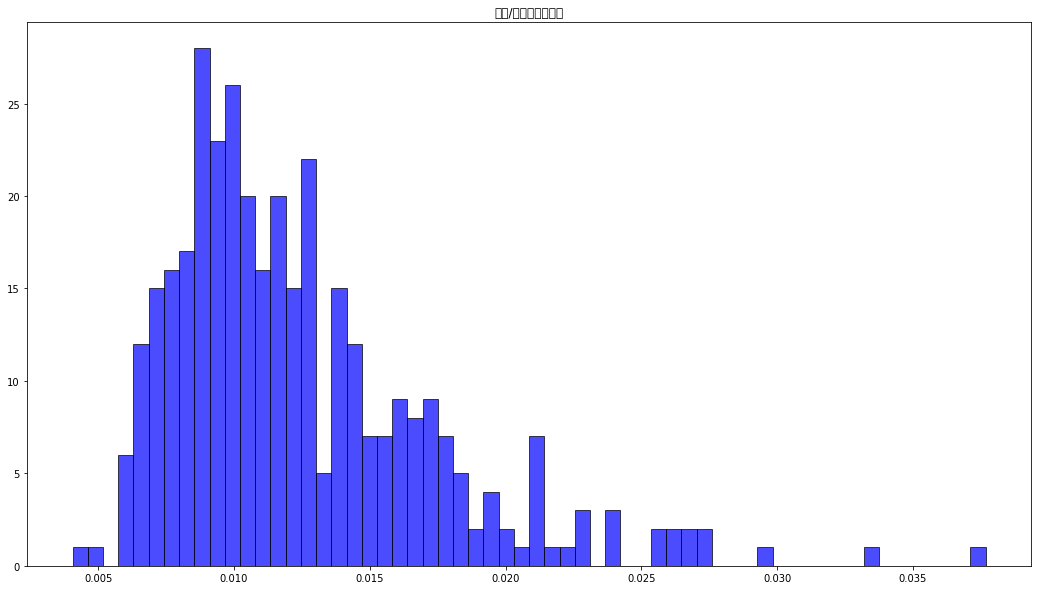

In [7]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.hist(np.array(test_scores)[itemindex_notis], bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

---
## 提取用于测试数据（噪声音频）的特征

In [31]:
import progressbar

bar = progressbar.ProgressBar(maxval=len(collect_files('./dataset/train/noise')),
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
print("Extracting features ...")
features = []

for i, (raw_file_name, joined_file_path) in enumerate(collect_files('./dataset/train/noise')):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    features.append(feats)
    bar.update(i + 1)

bar.finish()
print("Done.")

save(features, 'NOISE_fea', ".")

Extracting features ...


Done.


In [8]:
noise_fe = load('NOISE_fea')

# print(noise_fe)

print(np.array(noise_fe).shape)

noise_fe = np.array(noise_fe)

(334, 156)


In [9]:
noise_scores = []
for i in range(noise_fe.shape[0]):
    loss = autoencoder.evaluate(noise_fe[i:i+1], noise_fe[i:i+1], batch_size=1, verbose=0)
    noise_scores.append(loss)
    print('loss', loss)

loss 0.061532534658908844
loss 0.061164215207099915
loss 0.06902355700731277
loss 0.06604597717523575
loss 0.06728003919124603
loss 0.058621589094400406
loss 0.06755893677473068
loss 0.06399582326412201
loss 0.06001514568924904
loss 0.0627874881029129
loss 0.07394474744796753
loss 0.06676308810710907
loss 0.06351406127214432
loss 0.061642758548259735
loss 0.06784068793058395
loss 0.06429922580718994
loss 0.06120515614748001
loss 0.06386592239141464
loss 0.06418858468532562
loss 0.05789037421345711
loss 0.06682991981506348
loss 0.062262069433927536
loss 0.06969396024942398
loss 0.06630755960941315
loss 0.058289289474487305
loss 0.059450529515743256
loss 0.06036674231290817
loss 0.07146569341421127
loss 0.05839039012789726
loss 0.06864597648382187
loss 0.06618208438158035
loss 0.061504535377025604
loss 0.0661706030368805
loss 0.06238609179854393
loss 0.06707300990819931
loss 0.05985351279377937
loss 0.05785759165883064
loss 0.06681278347969055
loss 0.06173950433731079
loss 0.071569554507

---
## 将说话声（训练数据）的打分与噪声的打分花在直方图上进行对比

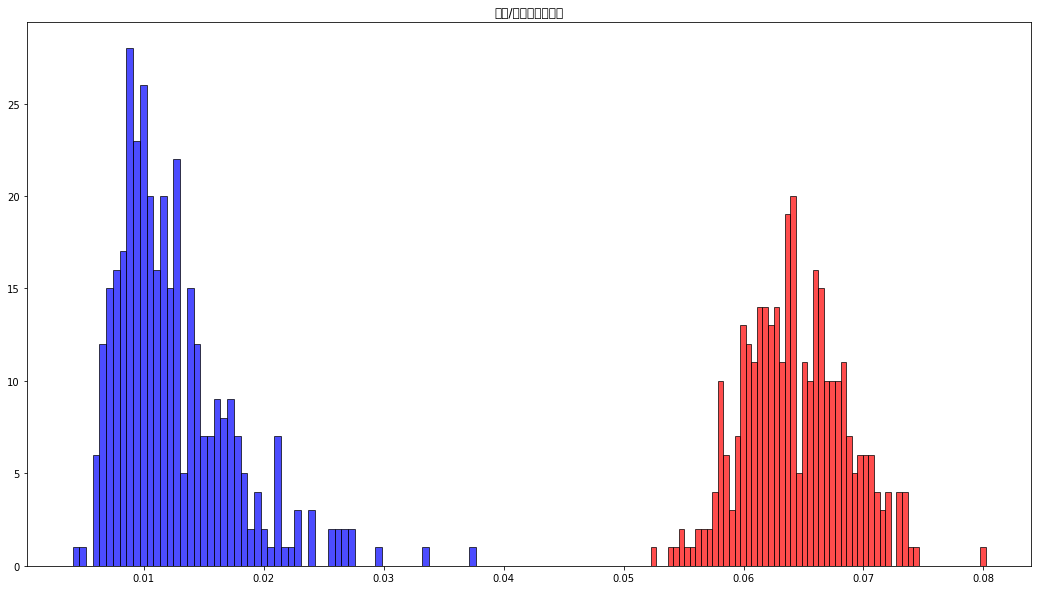

In [10]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(noise_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

---
## 以FM的下的211个音频来测试（87-108）

In [ ]:
import progressbar

bar = progressbar.ProgressBar(maxval=len(collect_files('../data_fm_424/radioAudio')),
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
print("Extracting features ...")
features = []

for i, (raw_file_name, joined_file_path) in enumerate(collect_files('../data_fm_424/radioAudio')):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    features.append(feats)
    bar.update(i + 1)

bar.finish()
print("Done.")

save(features, 'fm_fea', ".")

In [30]:
fm_fe = load('fm_fea')

print(np.array(fm_fe).shape)

fm_fe = np.array(fm_fe)

(211, 156)


In [31]:
fm_fe[0].shape

(156,)

In [32]:
fm_scores = []

for i in range(fm_fe.shape[0]):
    loss = autoencoder.evaluate(fm_fe[i:i+1], fm_fe[i:i+1], batch_size=1, verbose=0)
    fm_scores.append(loss)
    print('loss', loss)

loss 0.10157972574234009
loss 0.10703330487012863
loss 0.10689699649810791
loss 0.11819986253976822
loss 0.04084145650267601
loss 0.06980717182159424
loss 0.12014780193567276
loss 0.09251231700181961
loss 0.10885100811719894
loss 0.10875240713357925
loss 0.10882717370986938
loss 0.11275241523981094
loss 0.10012656450271606
loss 0.10871505737304688
loss 0.04681801050901413
loss 0.09233622997999191
loss 0.7175921201705933
loss 0.11717971414327621
loss 0.06392743438482285
loss 0.10977642238140106
loss 0.11370737105607986
loss 0.10905731469392776
loss 0.10905805230140686
loss 0.11478183418512344
loss 0.11481283605098724
loss 0.11586674302816391
loss 0.059784241020679474
loss 0.11037475615739822
loss 0.11032427102327347
loss 0.058452196419239044
loss 0.12272420525550842
loss 0.08743151277303696
loss 0.05573088675737381
loss 0.05791594460606575
loss 0.4201490581035614
loss 0.08732441067695618
loss 0.11393729597330093
loss 0.10932712256908417
loss 0.8798730373382568
loss 0.041990507394075394


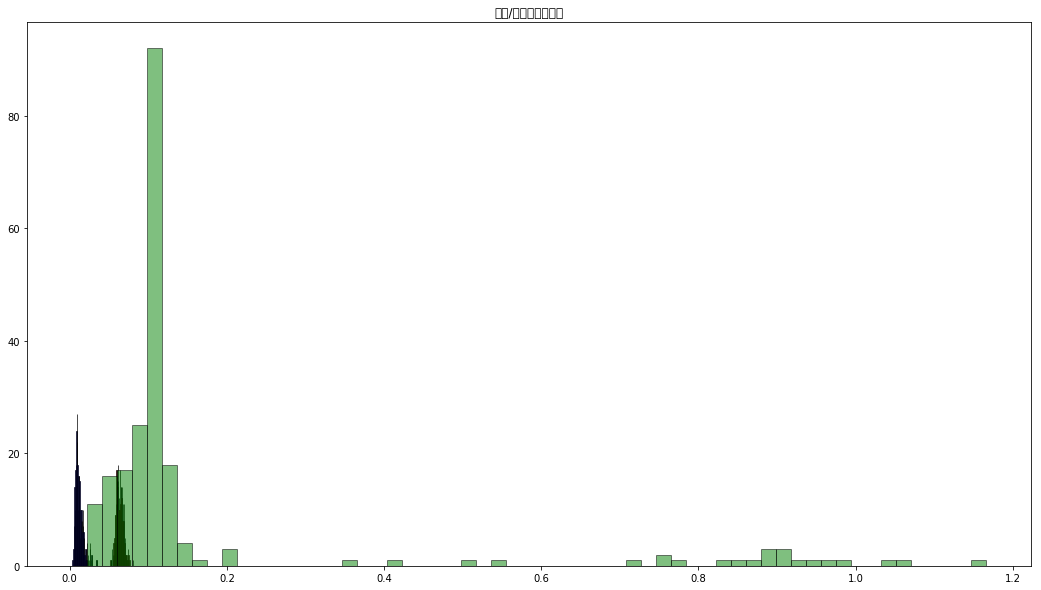

In [33]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(noise_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)
plt.hist(np.array(fm_scores), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [34]:
fm_s = np.array(fm_scores)

fm_ss=fm_s[fm_s<0.045]

In [35]:
len(fm_ss)

14

In [11]:
from tqdm import tqdm

print("Extracting features ...")
tmps = []

tmps_fm_scores = []
file_name = {}

for i, (raw_file_name, joined_file_path) in tqdm(enumerate(collect_files('../data_fm_424/radioAudio'))):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    loss = autoencoder.evaluate(feats.reshape(1,-1), feats.reshape(1,-1), batch_size=1, verbose=0)
    tmps_fm_scores.append(loss)
    if loss <=0.045:
        print("文件路径:{}, 文件名:{}, loss: {}".format(joined_file_path, raw_file_name, loss))
        file_name[raw_file_name]=loss
        
print("Done.")

Extracting features ...


6it [00:01,  4.12it/s]

文件路径:../data_fm_424/radioAudio/95.6MHz.wav, 文件名:95.6MHz, loss: 0.04212260991334915


40it [00:07,  5.56it/s]

文件路径:../data_fm_424/radioAudio/94.3MHz.wav, 文件名:94.3MHz, loss: 0.039334703236818314


53it [00:09,  5.40it/s]

文件路径:../data_fm_424/radioAudio/87.6MHz.wav, 文件名:87.6MHz, loss: 0.030029483139514923


55it [00:10,  5.48it/s]

文件路径:../data_fm_424/radioAudio/89.8MHz.wav, 文件名:89.8MHz, loss: 0.02828434482216835


77it [00:13,  6.43it/s]

文件路径:../data_fm_424/radioAudio/87.5MHz.wav, 文件名:87.5MHz, loss: 0.03356603533029556


88it [00:15,  6.40it/s]

文件路径:../data_fm_424/radioAudio/99.0MHz.wav, 文件名:99.0MHz, loss: 0.023507753387093544


116it [00:20,  6.28it/s]

文件路径:../data_fm_424/radioAudio/103.8MHz.wav, 文件名:103.8MHz, loss: 0.03432276472449303


139it [00:23,  6.41it/s]

文件路径:../data_fm_424/radioAudio/102.8MHz.wav, 文件名:102.8MHz, loss: 0.031177178025245667


141it [00:23,  6.41it/s]

文件路径:../data_fm_424/radioAudio/105.0MHz.wav, 文件名:105.0MHz, loss: 0.03035675548017025


161it [00:27,  6.24it/s]

文件路径:../data_fm_424/radioAudio/95.4MHz.wav, 文件名:95.4MHz, loss: 0.03641064465045929


167it [00:28,  6.12it/s]

文件路径:../data_fm_424/radioAudio/94.4MHz.wav, 文件名:94.4MHz, loss: 0.0409623458981514


178it [00:29,  6.35it/s]

文件路径:../data_fm_424/radioAudio/100.0MHz.wav, 文件名:100.0MHz, loss: 0.026895569637417793


188it [00:31,  5.92it/s]

文件路径:../data_fm_424/radioAudio/88.7MHz.wav, 文件名:88.7MHz, loss: 0.04161156341433525


211it [00:35,  6.22it/s]

Done.


In [12]:
tmps_fm_s= np.array(tmps_fm_scores)

tmps_fm_ss=tmps_fm_s[tmps_fm_s<0.045]

In [13]:
len(tmps_fm_ss)

13

In [14]:
file_name

{'95.6MHz': 0.04212260991334915,
 '94.3MHz': 0.039334703236818314,
 '87.6MHz': 0.030029483139514923,
 '89.8MHz': 0.02828434482216835,
 '87.5MHz': 0.03356603533029556,
 '99.0MHz': 0.023507753387093544,
 '103.8MHz': 0.03432276472449303,
 '102.8MHz': 0.031177178025245667,
 '105.0MHz': 0.03035675548017025,
 '95.4MHz': 0.03641064465045929,
 '94.4MHz': 0.0409623458981514,
 '100.0MHz': 0.026895569637417793,
 '88.7MHz': 0.04161156341433525}

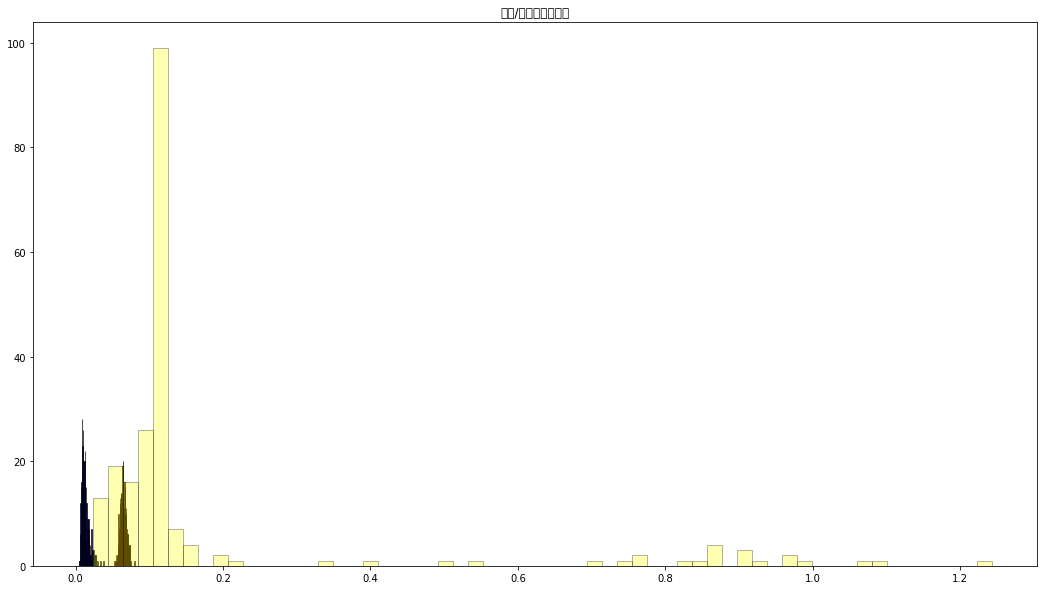

In [15]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(noise_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)
# plt.hist(np.array(fm_scores), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

plt.hist(np.array(tmps_fm_scores), bins=60, normed=0, facecolor="yellow", edgecolor="black", alpha=0.3)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

## 加载模型的代码   

    # encoding = utf-8

    import tqdm
    from pathlib import Path

    import keras
    from keras.models import load_model

    model = load_model(filepath)
    # loss = model.evaluate(x_test, y_test, batch_size=1, verbose=2)
    print('model:', model)

    # wf = open('label_.csv', 'a+')
    # one_class_label = 0
    # print('x_test', test[0].shape)
    # # loss = model.evaluate(test[:1], test[:1], batch_size=1, verbose=2)
    # # print('loss', loss)
    # for i in range(test.shape[0]):
    #     loss = model.evaluate(test[i:i+1], test[i:i+1], batch_size=1, verbose=0)
    #     # print('loss', loss)
    #     wf.write(str(one_class_label) + ',' + str(5) + ',' + str(loss) + '\n')
    #     print(i)
    # wf.close()

    # del model
    # gc.collect()

In [36]:
# encoding = utf-8

from tqdm import tqdm
from keras.models import load_model

model = load_model('autocode_0507.h5')
print('model:', model)

print("Extracting features ...")
tmps = []

tmps_fm_scores = []
file_name = {}

for i, (raw_file_name, joined_file_path) in tqdm(enumerate(collect_files('../radioAudio'))):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    loss = model.evaluate(feats.reshape(1,-1), feats.reshape(1,-1), batch_size=1, verbose=0)
    tmps_fm_scores.append(loss)
    if loss <=0.055:
        print("文件路径:{}, 文件名:{}, loss: {}".format(joined_file_path, raw_file_name, loss))
        file_name[raw_file_name]=loss
        
print("Done.")

0it [00:00, ?it/s]

model: <keras.engine.training.Model object at 0x7f90a87a7748>
Extracting features ...


6it [00:01,  5.38it/s]

文件路径:../radioAudio/95.6MHz.wav, 文件名:95.6MHz, loss: 0.0438782162964344
文件路径:../radioAudio/96.8MHz.wav, 文件名:96.8MHz, loss: 0.030199751257896423


20it [00:03,  5.89it/s]

文件路径:../radioAudio/97.0MHz.wav, 文件名:97.0MHz, loss: 0.04568968340754509


33it [00:05,  5.85it/s]

文件路径:../radioAudio/93.0MHz.wav, 文件名:93.0MHz, loss: 0.02331138215959072
文件路径:../radioAudio/90.8MHz.wav, 文件名:90.8MHz, loss: 0.0464005209505558


35it [00:06,  5.85it/s]

文件路径:../radioAudio/91.8MHz.wav, 文件名:91.8MHz, loss: 0.03648235648870468


41it [00:07,  5.90it/s]

文件路径:../radioAudio/94.3MHz.wav, 文件名:94.3MHz, loss: 0.043722961097955704


50it [00:08,  6.42it/s]

文件路径:../radioAudio/89.3MHz.wav, 文件名:89.3MHz, loss: 0.048409659415483475


53it [00:09,  6.71it/s]

文件路径:../radioAudio/87.6MHz.wav, 文件名:87.6MHz, loss: 0.030305715277791023


67it [00:11,  5.88it/s]

文件路径:../radioAudio/102.6MHz.wav, 文件名:102.6MHz, loss: 0.04274626448750496


70it [00:11,  5.90it/s]

文件路径:../radioAudio/100.8MHz.wav, 文件名:100.8MHz, loss: 0.05362986773252487


77it [00:13,  5.98it/s]

文件路径:../radioAudio/87.5MHz.wav, 文件名:87.5MHz, loss: 0.045158226042985916


88it [00:14,  6.13it/s]

文件路径:../radioAudio/99.0MHz.wav, 文件名:99.0MHz, loss: 0.036124467849731445


112it [00:18,  6.25it/s]

文件路径:../radioAudio/88.5MHz.wav, 文件名:88.5MHz, loss: 0.0278413575142622


137it [00:22,  5.86it/s]

文件路径:../radioAudio/100.6MHz.wav, 文件名:100.6MHz, loss: 0.03988482430577278


139it [00:23,  6.27it/s]

文件路径:../radioAudio/102.8MHz.wav, 文件名:102.8MHz, loss: 0.031725093722343445
文件路径:../radioAudio/105.7MHz.wav, 文件名:105.7MHz, loss: 0.05056300386786461


141it [00:23,  6.04it/s]

文件路径:../radioAudio/105.0MHz.wav, 文件名:105.0MHz, loss: 0.026094311848282814


143it [00:23,  5.92it/s]

文件路径:../radioAudio/95.3MHz.wav, 文件名:95.3MHz, loss: 0.044950760900974274


153it [00:25,  6.30it/s]

文件路径:../radioAudio/95.2MHz.wav, 文件名:95.2MHz, loss: 0.027468299493193626
文件路径:../radioAudio/98.9MHz.wav, 文件名:98.9MHz, loss: 0.040198300033807755


156it [00:25,  6.65it/s]

文件路径:../radioAudio/104.8MHz.wav, 文件名:104.8MHz, loss: 0.03209298849105835


161it [00:26,  6.01it/s]

文件路径:../radioAudio/95.4MHz.wav, 文件名:95.4MHz, loss: 0.026523079723119736
文件路径:../radioAudio/98.8MHz.wav, 文件名:98.8MHz, loss: 0.0251761581748724


163it [00:27,  5.93it/s]

文件路径:../radioAudio/105.6MHz.wav, 文件名:105.6MHz, loss: 0.0330529622733593
文件路径:../radioAudio/104.9MHz.wav, 文件名:104.9MHz, loss: 0.049574416130781174


167it [00:27,  5.95it/s]

文件路径:../radioAudio/94.4MHz.wav, 文件名:94.4MHz, loss: 0.049178265035152435


176it [00:29,  6.03it/s]

文件路径:../radioAudio/94.2MHz.wav, 文件名:94.2MHz, loss: 0.04755215346813202


178it [00:29,  5.92it/s]

文件路径:../radioAudio/100.0MHz.wav, 文件名:100.0MHz, loss: 0.021738942712545395


186it [00:31,  5.85it/s]

文件路径:../radioAudio/101.0MHz.wav, 文件名:101.0MHz, loss: 0.04693552106618881


188it [00:31,  5.79it/s]

文件路径:../radioAudio/88.7MHz.wav, 文件名:88.7MHz, loss: 0.022871144115924835


210it [00:35,  5.87it/s]

文件路径:../radioAudio/105.8MHz.wav, 文件名:105.8MHz, loss: 0.0376344658434391


211it [00:35,  5.85it/s]

文件路径:../radioAudio/99.8MHz.wav, 文件名:99.8MHz, loss: 0.02336904965341091
Done.


In [37]:
tmps_fm_s= np.array(tmps_fm_scores)

tmps_fm_ss=tmps_fm_s[tmps_fm_s<0.055]

In [38]:
file_name

{'95.6MHz': 0.0438782162964344,
 '96.8MHz': 0.030199751257896423,
 '97.0MHz': 0.04568968340754509,
 '93.0MHz': 0.02331138215959072,
 '90.8MHz': 0.0464005209505558,
 '91.8MHz': 0.03648235648870468,
 '94.3MHz': 0.043722961097955704,
 '89.3MHz': 0.048409659415483475,
 '87.6MHz': 0.030305715277791023,
 '102.6MHz': 0.04274626448750496,
 '100.8MHz': 0.05362986773252487,
 '87.5MHz': 0.045158226042985916,
 '99.0MHz': 0.036124467849731445,
 '88.5MHz': 0.0278413575142622,
 '100.6MHz': 0.03988482430577278,
 '102.8MHz': 0.031725093722343445,
 '105.7MHz': 0.05056300386786461,
 '105.0MHz': 0.026094311848282814,
 '95.3MHz': 0.044950760900974274,
 '95.2MHz': 0.027468299493193626,
 '98.9MHz': 0.040198300033807755,
 '104.8MHz': 0.03209298849105835,
 '95.4MHz': 0.026523079723119736,
 '98.8MHz': 0.0251761581748724,
 '105.6MHz': 0.0330529622733593,
 '104.9MHz': 0.049574416130781174,
 '94.4MHz': 0.049178265035152435,
 '94.2MHz': 0.04755215346813202,
 '100.0MHz': 0.021738942712545395,
 '101.0MHz': 0.04693552

In [39]:
fm_list = []
for key in file_name.keys():
#     print(key[:-3])
    fm_list.append(float(key[:-3]))


In [40]:
fm_list.sort()
print(fm_list)

[87.5, 87.6, 88.5, 88.7, 89.3, 90.8, 91.8, 93.0, 94.2, 94.3, 94.4, 95.2, 95.3, 95.4, 95.6, 96.8, 97.0, 98.8, 98.9, 99.0, 99.8, 100.0, 100.6, 100.8, 101.0, 102.6, 102.8, 104.8, 104.9, 105.0, 105.6, 105.7, 105.8]


In [41]:
# encoding = utf-8

from tqdm import tqdm
from keras.models import load_model

model = load_model('autocode_0507.h5')
print('model:', model)

print("Extracting features ...")
tmps = []

fm_87_scores = []
file_87_name = {}

for i, (raw_file_name, joined_file_path) in tqdm(enumerate(collect_files('../87.0'))):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    loss = model.evaluate(feats.reshape(1,-1), feats.reshape(1,-1), batch_size=1, verbose=0)
    fm_87_scores.append(loss)
    if loss <=0.055:
        print("文件路径:{}, 文件名:{}, loss: {}".format(joined_file_path, raw_file_name, loss))
        file_87_name[raw_file_name]=loss
        
print("Done.")

0it [00:00, ?it/s]

model: <keras.engine.training.Model object at 0x7f903048bda0>
Extracting features ...


/home/zhudong/.virtualenvs/tf_keras_py3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
142it [00:15,  9.26it/s]

Done.


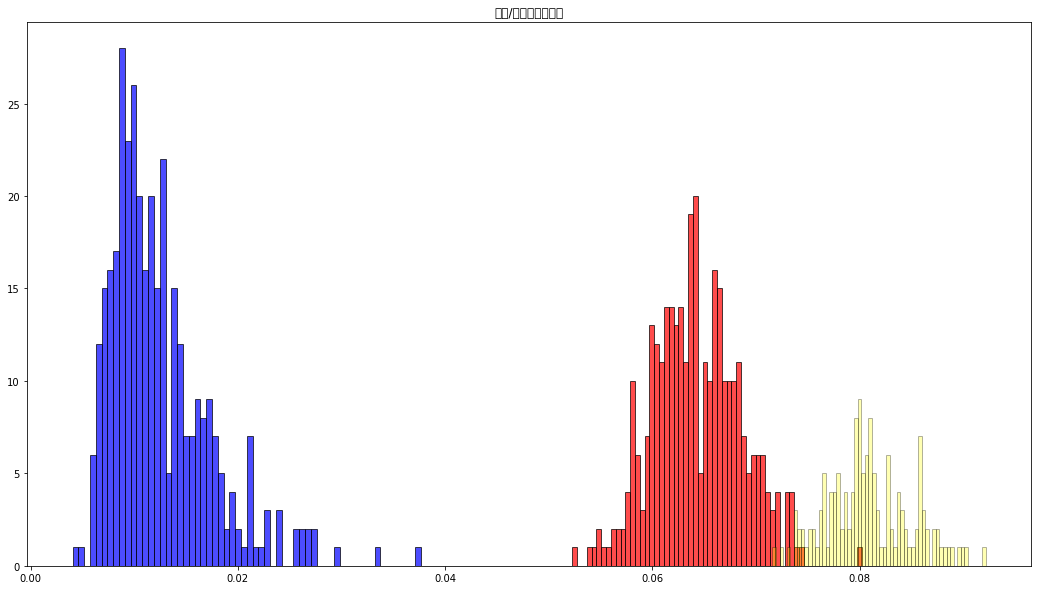

In [42]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(noise_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)
# plt.hist(np.array(fm_scores), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

plt.hist(np.array(fm_87_scores), bins=60, normed=0, facecolor="yellow", edgecolor="black", alpha=0.3)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [43]:
model = load_model('autocode_0507.h5')
print('model:', model)

print("Extracting features ...")
tmps = []

fm_101_7_scores = []
file_101_7_name = {}

for i, (raw_file_name, joined_file_path) in tqdm(enumerate(collect_files('../101.7'))):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    loss = model.evaluate(feats.reshape(1,-1), feats.reshape(1,-1), batch_size=1, verbose=0)
    fm_101_7_scores.append(loss)
    if loss <=0.055:
        print("文件路径:{}, 文件名:{}, loss: {}".format(joined_file_path, raw_file_name, loss))
        file_101_7_name[raw_file_name]=loss
        
print("Done.")

0it [00:00, ?it/s]

model: <keras.engine.training.Model object at 0x7f9011901908>
Extracting features ...


3it [00:00,  4.35it/s]

文件路径:../101.7/101.7-141.wav, 文件名:101.7-141, loss: 0.021060917526483536
文件路径:../101.7/101.7-98.wav, 文件名:101.7-98, loss: 0.01246307697147131
文件路径:../101.7/101.7-113.wav, 文件名:101.7-113, loss: 0.020972436293959618


5it [00:00,  5.38it/s]

文件路径:../101.7/101.7-34.wav, 文件名:101.7-34, loss: 0.014939618296921253
文件路径:../101.7/101.7-45.wav, 文件名:101.7-45, loss: 0.02973093092441559
文件路径:../101.7/101.7-24.wav, 文件名:101.7-24, loss: 0.011563943699002266


8it [00:00,  6.75it/s]

文件路径:../101.7/101.7-129.wav, 文件名:101.7-129, loss: 0.01718187890946865
文件路径:../101.7/101.7-58.wav, 文件名:101.7-58, loss: 0.032970622181892395


10it [00:01,  7.80it/s]

文件路径:../101.7/101.7-137.wav, 文件名:101.7-137, loss: 0.017407847568392754
文件路径:../101.7/101.7-122.wav, 文件名:101.7-122, loss: 0.024119460955262184


12it [00:01,  7.87it/s]

文件路径:../101.7/101.7-95.wav, 文件名:101.7-95, loss: 0.02563272789120674
文件路径:../101.7/101.7-140.wav, 文件名:101.7-140, loss: 0.014538723975419998


14it [00:01,  7.99it/s]

文件路径:../101.7/101.7-66.wav, 文件名:101.7-66, loss: 0.019016083329916
文件路径:../101.7/101.7-21.wav, 文件名:101.7-21, loss: 0.016789043322205544


16it [00:01,  7.83it/s]

文件路径:../101.7/101.7-148.wav, 文件名:101.7-148, loss: 0.0221218504011631
文件路径:../101.7/101.7-51.wav, 文件名:101.7-51, loss: 0.011264500208199024


18it [00:02,  8.45it/s]

文件路径:../101.7/101.7-23.wav, 文件名:101.7-23, loss: 0.026938915252685547
文件路径:../101.7/101.7-27.wav, 文件名:101.7-27, loss: 0.03009834885597229


19it [00:02,  8.21it/s]

文件路径:../101.7/101.7-70.wav, 文件名:101.7-70, loss: 0.02542719617486
文件路径:../101.7/101.7-74.wav, 文件名:101.7-74, loss: 0.008097791112959385


22it [00:02,  8.62it/s]

文件路径:../101.7/101.7-78.wav, 文件名:101.7-78, loss: 0.011749176308512688
文件路径:../101.7/101.7-110.wav, 文件名:101.7-110, loss: 0.015362410806119442


24it [00:02,  8.96it/s]

文件路径:../101.7/101.7-20.wav, 文件名:101.7-20, loss: 0.0128115713596344
文件路径:../101.7/101.7-84.wav, 文件名:101.7-84, loss: 0.016997674480080605


26it [00:03,  8.87it/s]

文件路径:../101.7/101.7-88.wav, 文件名:101.7-88, loss: 0.010452250950038433
文件路径:../101.7/101.7-82.wav, 文件名:101.7-82, loss: 0.03206854313611984


28it [00:03,  8.82it/s]

文件路径:../101.7/101.7-18.wav, 文件名:101.7-18, loss: 0.007333224173635244
文件路径:../101.7/101.7-92.wav, 文件名:101.7-92, loss: 0.011618776246905327


30it [00:03,  8.65it/s]

文件路径:../101.7/101.7-31.wav, 文件名:101.7-31, loss: 0.02125818282365799
文件路径:../101.7/101.7-48.wav, 文件名:101.7-48, loss: 0.011731859296560287


32it [00:03,  8.81it/s]

文件路径:../101.7/101.7-17.wav, 文件名:101.7-17, loss: 0.01952303759753704
文件路径:../101.7/101.7-86.wav, 文件名:101.7-86, loss: 0.01420547068119049


34it [00:03,  8.68it/s]

文件路径:../101.7/101.7-42.wav, 文件名:101.7-42, loss: 0.023641904816031456
文件路径:../101.7/101.7-121.wav, 文件名:101.7-121, loss: 0.014129400253295898


36it [00:04,  8.35it/s]

文件路径:../101.7/101.7-14.wav, 文件名:101.7-14, loss: 0.025734972208738327
文件路径:../101.7/101.7-91.wav, 文件名:101.7-91, loss: 0.011655772104859352


38it [00:04,  8.52it/s]

文件路径:../101.7/101.7-96.wav, 文件名:101.7-96, loss: 0.027303708717226982
文件路径:../101.7/101.7-37.wav, 文件名:101.7-37, loss: 0.020828653126955032


40it [00:04,  8.35it/s]

文件路径:../101.7/101.7-60.wav, 文件名:101.7-60, loss: 0.031774554401636124
文件路径:../101.7/101.7-123.wav, 文件名:101.7-123, loss: 0.018710771575570107


41it [00:04,  8.70it/s]

文件路径:../101.7/101.7-102.wav, 文件名:101.7-102, loss: 0.012524334713816643
文件路径:../101.7/101.7-9.wav, 文件名:101.7-9, loss: 0.013228598050773144
文件路径:../101.7/101.7-120.wav, 文件名:101.7-120, loss: 0.01616336591541767

44it [00:05,  8.71it/s]


文件路径:../101.7/101.7-116.wav, 文件名:101.7-116, loss: 0.012773805297911167


45it [00:05,  8.43it/s]

文件路径:../101.7/101.7-62.wav, 文件名:101.7-62, loss: 0.018885847181081772
文件路径:../101.7/101.7-25.wav, 文件名:101.7-25, loss: 0.016704583540558815


48it [00:05,  8.86it/s]

文件路径:../101.7/101.7-99.wav, 文件名:101.7-99, loss: 0.016049254685640335
文件路径:../101.7/101.7-87.wav, 文件名:101.7-87, loss: 0.01799769327044487


50it [00:05,  8.73it/s]

文件路径:../101.7/101.7-67.wav, 文件名:101.7-67, loss: 0.03262544050812721
文件路径:../101.7/101.7-89.wav, 文件名:101.7-89, loss: 0.009287982247769833


52it [00:06,  8.62it/s]

文件路径:../101.7/101.7-16.wav, 文件名:101.7-16, loss: 0.019263507798314095
文件路径:../101.7/101.7-144.wav, 文件名:101.7-144, loss: 0.009689145721495152


54it [00:06,  8.12it/s]

文件路径:../101.7/101.7-133.wav, 文件名:101.7-133, loss: 0.013328981585800648
文件路径:../101.7/101.7-114.wav, 文件名:101.7-114, loss: 0.01833774708211422


55it [00:06,  8.29it/s]

文件路径:../101.7/101.7-128.wav, 文件名:101.7-128, loss: 0.013660015538334846
文件路径:../101.7/101.7-75.wav, 文件名:101.7-75, loss: 0.02054101601243019


58it [00:06,  8.72it/s]

文件路径:../101.7/101.7-108.wav, 文件名:101.7-108, loss: 0.014877287670969963
文件路径:../101.7/101.7-44.wav, 文件名:101.7-44, loss: 0.021256962791085243


60it [00:06,  9.02it/s]

文件路径:../101.7/101.7-41.wav, 文件名:101.7-41, loss: 0.014346200972795486
文件路径:../101.7/101.7-109.wav, 文件名:101.7-109, loss: 0.008557884953916073


62it [00:07,  8.93it/s]

文件路径:../101.7/101.7-8.wav, 文件名:101.7-8, loss: 0.03694426268339157
文件路径:../101.7/101.7-131.wav, 文件名:101.7-131, loss: 0.01379676628857851


64it [00:07,  8.24it/s]

文件路径:../101.7/101.7-65.wav, 文件名:101.7-65, loss: 0.03054051287472248
文件路径:../101.7/101.7-138.wav, 文件名:101.7-138, loss: 0.015421473421156406


65it [00:07,  8.03it/s]

文件路径:../101.7/101.7-50.wav, 文件名:101.7-50, loss: 0.014463305473327637
文件路径:../101.7/101.7.wav, 文件名:101.7, loss: 0.016541391611099243


67it [00:07,  8.30it/s]

文件路径:../101.7/101.7-115.wav, 文件名:101.7-115, loss: 0.013313226401805878
文件路径:../101.7/101.7-6.wav, 文件名:101.7-6, loss: 0.015583371743559837
文件路径:../101.7/101.7-97.wav, 文件名:101.7-97, loss: 0.020400624722242355

70it [00:08,  8.48it/s]


文件路径:../101.7/101.7-130.wav, 文件名:101.7-130, loss: 0.027967100962996483


72it [00:08,  8.54it/s]

文件路径:../101.7/101.7-40.wav, 文件名:101.7-40, loss: 0.011192334815859795
文件路径:../101.7/101.7-72.wav, 文件名:101.7-72, loss: 0.014181740581989288


74it [00:08,  8.39it/s]

文件路径:../101.7/101.7-90.wav, 文件名:101.7-90, loss: 0.016609754413366318
文件路径:../101.7/101.7-77.wav, 文件名:101.7-77, loss: 0.00962863676249981


76it [00:08,  8.09it/s]

文件路径:../101.7/101.7-46.wav, 文件名:101.7-46, loss: 0.020797817036509514
文件路径:../101.7/101.7-73.wav, 文件名:101.7-73, loss: 0.018094724044203758


78it [00:09,  8.64it/s]

文件路径:../101.7/101.7-5.wav, 文件名:101.7-5, loss: 0.02362530119717121
文件路径:../101.7/101.7-19.wav, 文件名:101.7-19, loss: 0.018951332196593285


80it [00:09,  8.53it/s]

文件路径:../101.7/101.7-33.wav, 文件名:101.7-33, loss: 0.011599602177739143
文件路径:../101.7/101.7-29.wav, 文件名:101.7-29, loss: 0.014769595116376877


82it [00:09,  8.27it/s]

文件路径:../101.7/101.7-61.wav, 文件名:101.7-61, loss: 0.03818529471755028
文件路径:../101.7/101.7-83.wav, 文件名:101.7-83, loss: 0.048788536339998245


83it [00:09,  8.26it/s]

文件路径:../101.7/101.7-146.wav, 文件名:101.7-146, loss: 0.02001342549920082
文件路径:../101.7/101.7-30.wav, 文件名:101.7-30, loss: 0.018847573548555374


86it [00:09,  8.69it/s]

文件路径:../101.7/101.7-69.wav, 文件名:101.7-69, loss: 0.015847375616431236
文件路径:../101.7/101.7-104.wav, 文件名:101.7-104, loss: 0.013191137462854385


87it [00:10,  8.77it/s]

文件路径:../101.7/101.7-145.wav, 文件名:101.7-145, loss: 0.01664612628519535
文件路径:../101.7/101.7-28.wav, 文件名:101.7-28, loss: 0.01794940046966076


89it [00:10,  8.44it/s]

文件路径:../101.7/101.7-142.wav, 文件名:101.7-142, loss: 0.02181308902800083
文件路径:../101.7/101.7-79.wav, 文件名:101.7-79, loss: 0.01476133894175291


92it [00:10,  8.96it/s]

文件路径:../101.7/101.7-119.wav, 文件名:101.7-119, loss: 0.019811512902379036
文件路径:../101.7/101.7-52.wav, 文件名:101.7-52, loss: 0.013597765006124973


94it [00:10,  9.12it/s]

文件路径:../101.7/101.7-105.wav, 文件名:101.7-105, loss: 0.018366772681474686
文件路径:../101.7/101.7-26.wav, 文件名:101.7-26, loss: 0.017158368602395058


95it [00:11,  8.52it/s]

文件路径:../101.7/101.7-64.wav, 文件名:101.7-64, loss: 0.027898892760276794
文件路径:../101.7/101.7-10.wav, 文件名:101.7-10, loss: 0.0184036698192358


98it [00:11,  8.81it/s]

文件路径:../101.7/101.7-103.wav, 文件名:101.7-103, loss: 0.019448256120085716
文件路径:../101.7/101.7-135.wav, 文件名:101.7-135, loss: 0.008761359378695488


101it [00:11, 10.20it/s]

文件路径:../101.7/101.7-35.wav, 文件名:101.7-35, loss: 0.015496520325541496
文件路径:../101.7/101.7-143.wav, 文件名:101.7-143, loss: 0.016454163938760757


103it [00:11, 10.15it/s]

文件路径:../101.7/101.7-111.wav, 文件名:101.7-111, loss: 0.013610659167170525
文件路径:../101.7/101.7-11.wav, 文件名:101.7-11, loss: 0.010194477625191212


105it [00:12,  9.46it/s]

文件路径:../101.7/101.7-68.wav, 文件名:101.7-68, loss: 0.022024579346179962
文件路径:../101.7/101.7-7.wav, 文件名:101.7-7, loss: 0.013494782149791718


107it [00:12,  8.83it/s]

文件路径:../101.7/101.7-2.wav, 文件名:101.7-2, loss: 0.023827800527215004
文件路径:../101.7/101.7-136.wav, 文件名:101.7-136, loss: 0.016051160171628


109it [00:12,  8.50it/s]

文件路径:../101.7/101.7-55.wav, 文件名:101.7-55, loss: 0.011429384350776672
文件路径:../101.7/101.7-57.wav, 文件名:101.7-57, loss: 0.013138622976839542


111it [00:12,  8.45it/s]

文件路径:../101.7/101.7-63.wav, 文件名:101.7-63, loss: 0.01665620692074299
文件路径:../101.7/101.7-107.wav, 文件名:101.7-107, loss: 0.01716170459985733


112it [00:12,  8.18it/s]

文件路径:../101.7/101.7-134.wav, 文件名:101.7-134, loss: 0.01675364561378956
文件路径:../101.7/101.7-94.wav, 文件名:101.7-94, loss: 0.011941349133849144


115it [00:13,  8.86it/s]

文件路径:../101.7/101.7-132.wav, 文件名:101.7-132, loss: 0.022562434896826744
文件路径:../101.7/101.7-36.wav, 文件名:101.7-36, loss: 0.035268545150756836


117it [00:13,  9.15it/s]

文件路径:../101.7/101.7-32.wav, 文件名:101.7-32, loss: 0.02213859185576439
文件路径:../101.7/101.7-106.wav, 文件名:101.7-106, loss: 0.01077903714030981


119it [00:13,  8.31it/s]

文件路径:../101.7/101.7-59.wav, 文件名:101.7-59, loss: 0.023070409893989563
文件路径:../101.7/101.7-126.wav, 文件名:101.7-126, loss: 0.013938131742179394


121it [00:13,  8.70it/s]

文件路径:../101.7/101.7-13.wav, 文件名:101.7-13, loss: 0.01349392905831337
文件路径:../101.7/101.7-124.wav, 文件名:101.7-124, loss: 0.01496096421033144


123it [00:14,  8.67it/s]

文件路径:../101.7/101.7-47.wav, 文件名:101.7-47, loss: 0.006077243946492672
文件路径:../101.7/101.7-127.wav, 文件名:101.7-127, loss: 0.022791415452957153


124it [00:14,  8.31it/s]

文件路径:../101.7/101.7-147.wav, 文件名:101.7-147, loss: 0.021612316370010376
文件路径:../101.7/101.7-15.wav, 文件名:101.7-15, loss: 0.018110835924744606


127it [00:14,  8.63it/s]

文件路径:../101.7/101.7-76.wav, 文件名:101.7-76, loss: 0.007707037031650543
文件路径:../101.7/101.7-49.wav, 文件名:101.7-49, loss: 0.01406213827431202


128it [00:14,  8.66it/s]

文件路径:../101.7/101.7-81.wav, 文件名:101.7-81, loss: 0.019067307934165
文件路径:../101.7/101.7-38.wav, 文件名:101.7-38, loss: 0.018814973533153534


132it [00:15,  9.23it/s]

文件路径:../101.7/101.7-80.wav, 文件名:101.7-80, loss: 0.025677701458334923
文件路径:../101.7/101.7-3.wav, 文件名:101.7-3, loss: 0.023298706859350204
文件路径:../101.7/101.7-39.wav, 文件名:101.7-39, loss: 0.010233360342681408


133it [00:15,  9.29it/s]

文件路径:../101.7/101.7-117.wav, 文件名:101.7-117, loss: 0.024615420028567314
文件路径:../101.7/101.7-100.wav, 文件名:101.7-100, loss: 0.017436353489756584


136it [00:15,  8.79it/s]

文件路径:../101.7/101.7-125.wav, 文件名:101.7-125, loss: 0.011353077366948128
文件路径:../101.7/101.7-85.wav, 文件名:101.7-85, loss: 0.017061356455087662


139it [00:15,  9.12it/s]

文件路径:../101.7/101.7-112.wav, 文件名:101.7-112, loss: 0.010577049106359482
文件路径:../101.7/101.7-22.wav, 文件名:101.7-22, loss: 0.017138205468654633
文件路径:../101.7/101.7-12.wav, 文件名:101.7-12, loss: 0.016195425763726234


141it [00:16,  8.92it/s]

文件路径:../101.7/101.7-54.wav, 文件名:101.7-54, loss: 0.01044192723929882
文件路径:../101.7/101.7-93.wav, 文件名:101.7-93, loss: 0.011084542609751225


142it [00:16,  8.57it/s]

文件路径:../101.7/101.7-71.wav, 文件名:101.7-71, loss: 0.014375564642250538
文件路径:../101.7/101.7-118.wav, 文件名:101.7-118, loss: 0.01986677385866642


145it [00:16,  8.94it/s]

文件路径:../101.7/101.7-56.wav, 文件名:101.7-56, loss: 0.011997301131486893
文件路径:../101.7/101.7-43.wav, 文件名:101.7-43, loss: 0.016974300146102905


147it [00:16,  9.04it/s]

文件路径:../101.7/101.7-101.wav, 文件名:101.7-101, loss: 0.012683735229074955
文件路径:../101.7/101.7-139.wav, 文件名:101.7-139, loss: 0.010906888172030449


149it [00:16,  8.77it/s]

文件路径:../101.7/101.7-53.wav, 文件名:101.7-53, loss: 0.01714482344686985
文件路径:../101.7/101.7-4.wav, 文件名:101.7-4, loss: 0.015368673950433731
Done.


In [49]:
tmp_fm_101_7_scores= np.array(fm_101_7_scores)

tmp_fm_101_7_scores_s=tmp_fm_101_7_scores[tmp_fm_101_7_scores<0.55]

In [51]:
len(tmp_fm_101_7_scores_s)

148

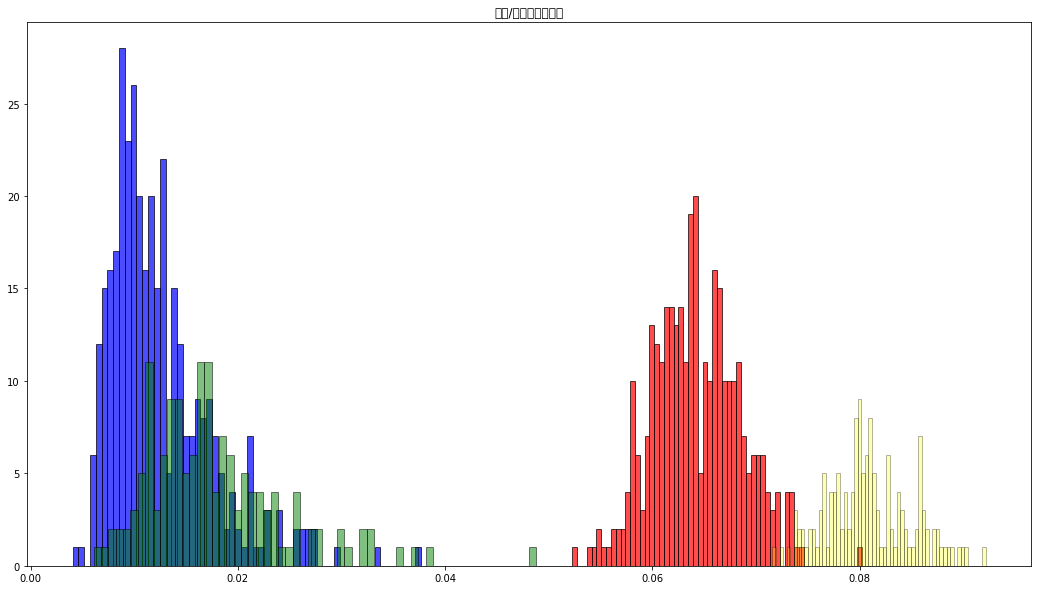

In [50]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(noise_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)
plt.hist(np.array(tmp_fm_101_7_scores_s), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

plt.hist(np.array(fm_87_scores), bins=60, normed=0, facecolor="yellow", edgecolor="black", alpha=0.3)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [52]:
model = load_model('autocode_0507.h5')
print('model:', model)

print("Extracting features ...")
tmps = []

fm_101_7_scores = []
file_101_7_name = {}

for i, (raw_file_name, joined_file_path) in tqdm(enumerate(collect_files('../102.5'))):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    loss = model.evaluate(feats.reshape(1,-1), feats.reshape(1,-1), batch_size=1, verbose=0)
    fm_101_7_scores.append(loss)
#     if loss <=0.055:
    print("文件路径:{}, 文件名:{}, loss: {}".format(joined_file_path, raw_file_name, loss))
    file_101_7_name[raw_file_name]=loss
        
print("Done.")

0it [00:00, ?it/s]

model: <keras.engine.training.Model object at 0x7f90119c66a0>
Extracting features ...


1it [00:00,  2.96it/s]

文件路径:../102.5/102.5MHz.wav, 文件名:102.5MHz, loss: 0.1203848123550415
Done.


---
# 以噪声数据作为训练，以有说话声数据作为测试

**【注意：】重复上述步骤，不同之处在于将训练数据和测试数据交换**

In [39]:
# training
autoencoder.fit(noise_fe, noise_fe, epochs=10, batch_size=10, shuffle=True)

filepath = 'autocode_0507.h5'
autoencoder.save(filepath)

# plotting
loss = autoencoder.evaluate(noise_fe, noise_fe, batch_size=1, verbose=2)
print('测试集损失函数值：', loss)
decoded_imgs = autoencoder.predict(noise_fe)
print(decoded_imgs)

Epoch 1/10
334/334 [==============================] - 0s 363us/step - loss: 0.0173
Epoch 2/10
334/334 [==============================] - 0s 346us/step - loss: 0.0056
Epoch 3/10
334/334 [==============================] - 0s 325us/step - loss: 0.0053
Epoch 4/10
334/334 [==============================] - 0s 331us/step - loss: 0.0052
Epoch 5/10
334/334 [==============================] - 0s 331us/step - loss: 0.0053
Epoch 6/10
334/334 [==============================] - 0s 343us/step - loss: 0.0052
Epoch 7/10
334/334 [==============================] - 0s 331us/step - loss: 0.0051
Epoch 8/10
334/334 [==============================] - 0s 330us/step - loss: 0.0051
Epoch 9/10
334/334 [==============================] - 0s 350us/step - loss: 0.0050
Epoch 10/10
334/334 [==============================] - 0s 339us/step - loss: 0.0050
测试集损失函数值： 0.00515253807300936
[[ 1.4599336   1.5503818   0.7767413  ... -0.2786408  -0.2943708
  -0.2949549 ]
 [ 1.4685991   1.5173404   0.7384685  ... -0.29599574 -0.28

In [40]:
from tqdm import tqdm

scores = []
for i in range(noise_fe.shape[0]):
    loss = autoencoder.evaluate(noise_fe[i:i+1], noise_fe[i:i+1], batch_size=1, verbose=0)
    scores.append(loss)
    print('loss', loss)

loss 0.005302530247718096
loss 0.005641177296638489
loss 0.006763818208128214
loss 0.004816441796720028
loss 0.005971752572804689
loss 0.005134917795658112
loss 0.006862388923764229
loss 0.006936227437108755
loss 0.0034283995628356934
loss 0.003919665236026049
loss 0.010512681677937508
loss 0.0034363793674856424
loss 0.006046351511031389
loss 0.003855158109217882
loss 0.005036135204136372
loss 0.005098969209939241
loss 0.0039811828173696995
loss 0.004129835404455662
loss 0.007984868250787258
loss 0.005053576081991196
loss 0.003773013362661004
loss 0.006672649644315243
loss 0.007932454347610474
loss 0.0042542265728116035
loss 0.0032157045789062977
loss 0.005454070866107941
loss 0.004209902137517929
loss 0.005770671647042036
loss 0.00455111637711525
loss 0.0025018928572535515
loss 0.007596881128847599
loss 0.005067767109721899
loss 0.005321423523128033
loss 0.006190894171595573
loss 0.004588901065289974
loss 0.005828323308378458
loss 0.0026442985981702805
loss 0.004713956732302904
loss 0

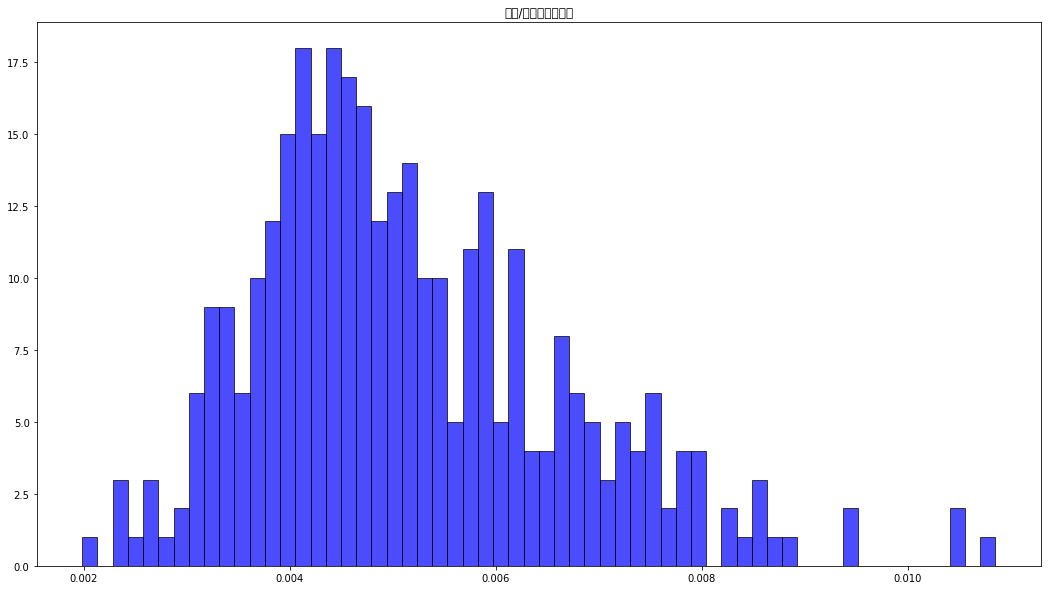

In [41]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.hist(np.array(test_scores)[itemindex_notis], bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [42]:
speech_fe = load('SPEECH_FEA')

# print(speech_fe)

print(np.array(speech_fe).shape)

speech_fe = np.array(speech_fe)

(357, 156)


In [43]:
speech_scores = []
for i in range(speech_fe.shape[0]):
    loss = autoencoder.evaluate(speech_fe[i:i+1], speech_fe[i:i+1], batch_size=1, verbose=0)
    speech_scores.append(loss)
    print('loss', loss)

loss 0.10750097036361694
loss 0.11997967213392258
loss 0.0979476124048233
loss 0.08926428109407425
loss 0.13152611255645752
loss 0.10344737768173218
loss 0.09446696937084198
loss 0.15363582968711853
loss 0.15640446543693542
loss 0.09123775362968445
loss 0.08848904073238373
loss 0.07048458606004715
loss 0.0739508718252182
loss 0.11748676747083664
loss 0.11096689105033875
loss 0.09309348464012146
loss 0.07870776951313019
loss 0.17532901465892792
loss 0.09473519772291183
loss 0.10392455756664276
loss 0.09763709455728531
loss 0.10547998547554016
loss 0.12166094034910202
loss 0.19769969582557678
loss 0.11239976435899734
loss 0.11801868677139282
loss 0.1422601044178009
loss 0.1639672964811325
loss 0.14558546245098114
loss 0.13519176840782166
loss 0.09964682161808014
loss 0.14846213161945343
loss 0.10495235025882721
loss 0.16254036128520966
loss 0.13352340459823608
loss 0.13941214978694916
loss 0.106388621032238
loss 0.07033293694257736
loss 0.13813908398151398
loss 0.12552836537361145
loss 0

loss 0.11449142545461655
loss 0.08202391862869263
loss 0.07754773646593094
loss 0.08585453033447266
loss 0.13152888417243958
loss 0.11321321129798889
loss 0.11449383199214935
loss 0.09186940640211105


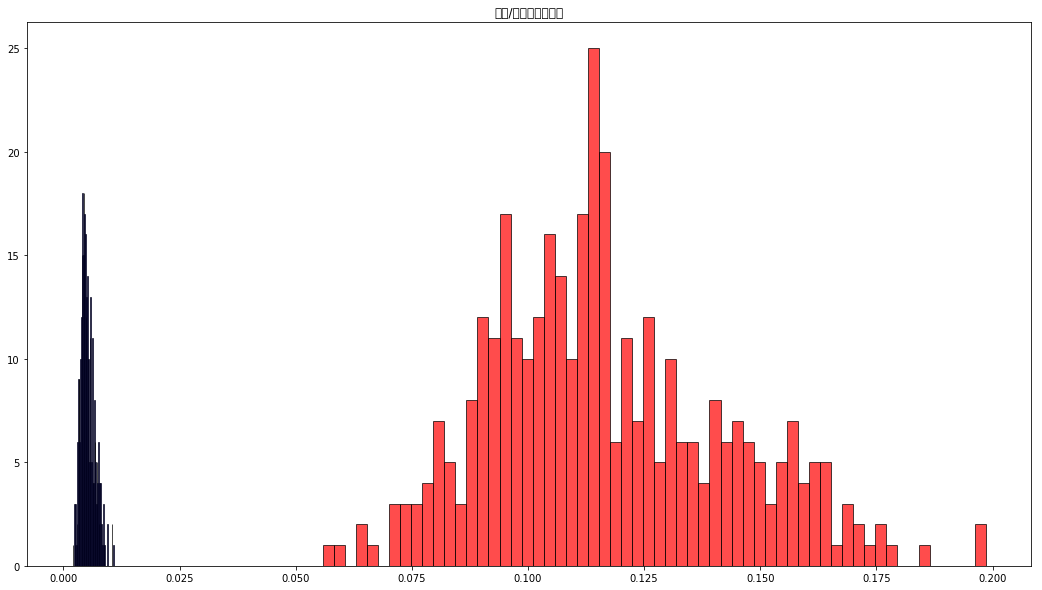

In [46]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(speech_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

---
# 用87到108的音频数据测试

In [47]:
import progressbar

bar = progressbar.ProgressBar(maxval=len(collect_files('../data_fm_424/radioAudio')),
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
print("Extracting features ...")
features = []

for i, (raw_file_name, joined_file_path) in enumerate(collect_files('../data_fm_424/radioAudio')):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    features.append(feats)
    bar.update(i + 1)

bar.finish()
print("Done.")

save(features, 'fm_fea', ".")

Extracting features ...


Done.


In [51]:
fm_fe = load('fm_fea')

print(np.array(fm_fe).shape)

fm_fe = np.array(fm_fe)

(211, 156)


In [52]:
fm_scores = []

for i in range(fm_fe.shape[0]):
    loss = autoencoder.evaluate(fm_fe[i:i+1], fm_fe[i:i+1], batch_size=1, verbose=0)
    fm_scores.append(loss)
    print('loss', loss)

loss 0.04476483538746834
loss 0.0464886911213398
loss 0.04738059639930725
loss 0.055219393223524094
loss 0.11144540458917618
loss 0.15102405846118927
loss 0.05063514783978462
loss 0.038193002343177795
loss 0.048073962330818176
loss 0.04587000235915184
loss 0.04841231927275658
loss 0.051839448511600494
loss 0.042625248432159424
loss 0.050033118575811386
loss 0.056313950568437576
loss 0.040464162826538086
loss 0.8188708424568176
loss 0.2668059468269348
loss 0.17014461755752563
loss 0.047304973006248474
loss 0.04898422583937645
loss 0.05041803792119026
loss 0.05184570327401161
loss 0.05257118493318558
loss 0.05262879654765129
loss 0.05260411277413368
loss 0.038271501660346985
loss 0.05111467465758324
loss 0.053398482501506805
loss 0.09415283799171448
loss 0.056241102516651154
loss 0.22338630259037018
loss 0.06214487925171852
loss 0.19126205146312714
loss 0.538007378578186
loss 0.050530556589365005
loss 0.051353443413972855
loss 0.1758962869644165
loss 0.9856024384498596
loss 0.05672967061

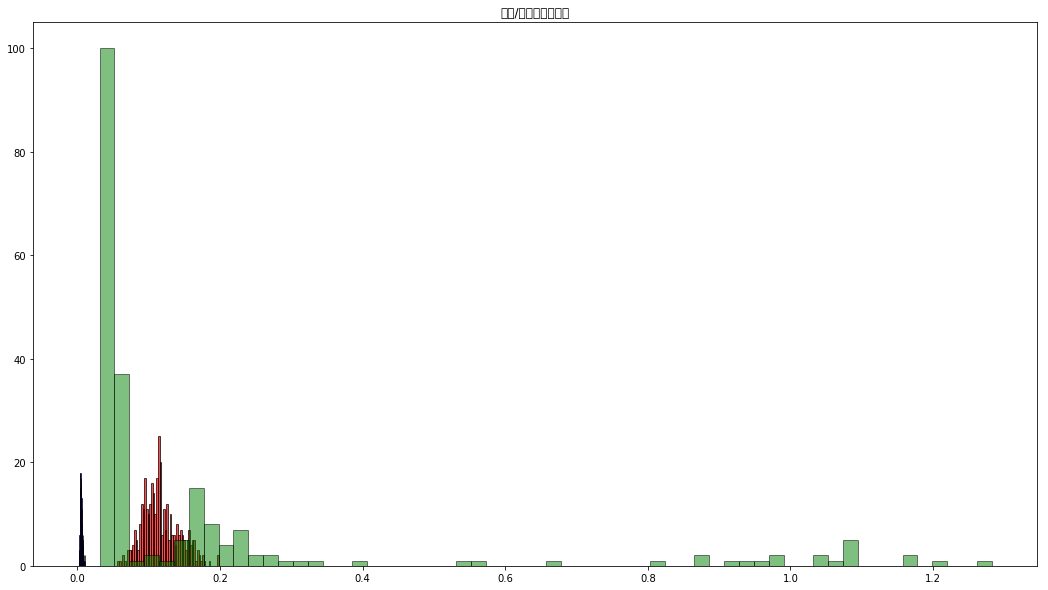

In [55]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(speech_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)
plt.hist(np.array(fm_scores), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

---
# 一条音频一天音频地加载

**输出对应的文件名和得分**

In [29]:
from tqdm import tqdm

print("Extracting features ...")
tmps = []

tmps_fm_scores = []

for i, (raw_file_name, joined_file_path) in tqdm(enumerate(collect_files('../data_fm_424/radioAudio'))):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    loss = autoencoder.evaluate(feats.reshape(1,-1), feats.reshape(1,-1), batch_size=1, verbose=0)
    tmps_fm_scores.append(loss)
    if loss <=0.045:
        print("文件路径:{}, 文件名:{}, loss: {}".format(joined_file_path, raw_file_name, loss))

print("Done.")

0it [00:00, ?it/s]

Extracting features ...
88.0MHz ../data_fm_424/radioAudio/88.0MHz.wav
Done.


# 

In [57]:
import progressbar

bar = progressbar.ProgressBar(maxval=len(collect_files('../nosie_0508/train')),
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
print("Extracting features ...")
features = []

for i, (raw_file_name, joined_file_path) in enumerate(collect_files('../nosie_0508/train')):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    features.append(feats)
    bar.update(i + 1)

bar.finish()
print("Done.")

save(features, 'NOISE_0508_fea', ".")

Extracting features ...


Done.


In [58]:
noise_0508_fe = load('NOISE_0508_fea')

print(np.array(noise_0508_fe).shape)

noise_0508_fe = np.array(noise_0508_fe)

(621, 156)


In [59]:
# training
autoencoder.fit(noise_0508_fe, noise_0508_fe, epochs=10, batch_size=10, shuffle=True)

filepath = 'autocode_0507.h5'
autoencoder.save(filepath)

# plotting
loss = autoencoder.evaluate(noise_0508_fe, noise_0508_fe, batch_size=1, verbose=2)
print('测试集损失函数值：', loss)
decoded_imgs = autoencoder.predict(noise_0508_fe)
print(decoded_imgs)

Epoch 1/10
621/621 [==============================] - 0s 416us/step - loss: 0.0139
Epoch 2/10
621/621 [==============================] - 0s 354us/step - loss: 0.0056
Epoch 3/10
621/621 [==============================] - 0s 356us/step - loss: 0.0054
Epoch 4/10
621/621 [==============================] - 0s 371us/step - loss: 0.0053
Epoch 5/10
621/621 [==============================] - 0s 388us/step - loss: 0.0052
Epoch 6/10
621/621 [==============================] - 0s 367us/step - loss: 0.0051
Epoch 7/10
621/621 [==============================] - 0s 349us/step - loss: 0.0049
Epoch 8/10
621/621 [==============================] - 0s 351us/step - loss: 0.0049
Epoch 9/10
621/621 [==============================] - 0s 352us/step - loss: 0.0048
Epoch 10/10
621/621 [==============================] - 0s 375us/step - loss: 0.0047
测试集损失函数值： 0.004657503825780334
[[ 0.91030455  1.4125906   0.3612656  ... -0.2331432  -0.22142406
  -0.23302558]
 [ 0.87573975  1.3826294   0.25922582 ... -0.20093828 -0.

In [60]:
from tqdm import tqdm

scores = []
for i in range(noise_0508_fe.shape[0]):
    loss = autoencoder.evaluate(noise_0508_fe[i:i+1], noise_0508_fe[i:i+1], batch_size=1, verbose=0)
    scores.append(loss)
    print('loss', loss)

loss 0.00538501376286149
loss 0.003692004131153226
loss 0.007362694945186377
loss 0.0029913100879639387
loss 0.002590617397800088
loss 0.005611713510006666
loss 0.009102736599743366
loss 0.002715183887630701
loss 0.0038435000460594893
loss 0.0044237347319722176
loss 0.0022620621602982283
loss 0.003914892207831144
loss 0.0032166813034564257
loss 0.007529530208557844
loss 0.005483279470354319
loss 0.0031832472886890173
loss 0.005407434888184071
loss 0.004595561884343624
loss 0.004408349748700857
loss 0.003770835930481553
loss 0.0037247431464493275
loss 0.0026520234532654285
loss 0.004577308893203735
loss 0.004036122467368841
loss 0.004854714497923851
loss 0.0049291071482002735
loss 0.003676289226859808
loss 0.0030726895201951265
loss 0.004517987836152315
loss 0.0045930733904242516
loss 0.0029514252673834562
loss 0.006325057242065668
loss 0.004821194801479578
loss 0.005686795338988304
loss 0.00395584013313055
loss 0.004406804218888283
loss 0.005257883109152317
loss 0.009895799681544304
lo

loss 0.00550517113879323
loss 0.006829822901636362
loss 0.0048446254804730415
loss 0.0054086847230792046
loss 0.0033381956163793802
loss 0.004152454435825348
loss 0.005262495018541813
loss 0.005306934472173452
loss 0.004664430860430002
loss 0.004751909989863634
loss 0.004631999414414167
loss 0.0066362181678414345
loss 0.004446878097951412
loss 0.005969853140413761
loss 0.005566867999732494
loss 0.004051114432513714
loss 0.0033957636915147305
loss 0.006604551337659359
loss 0.005940152797847986
loss 0.003917761147022247
loss 0.0037598663475364447
loss 0.007933218963444233
loss 0.0056784143671393394
loss 0.0055106994695961475
loss 0.0042324974201619625
loss 0.004332450684159994
loss 0.0032918460201472044
loss 0.005217366386204958
loss 0.003863676218315959
loss 0.002974248491227627
loss 0.0038960271049290895
loss 0.0031274098437279463
loss 0.0042541190050542355
loss 0.004529809113591909
loss 0.005050045903772116
loss 0.005053478293120861
loss 0.005928144324570894
loss 0.006175278685986996


/home/zhudong/.virtualenvs/tf_keras_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


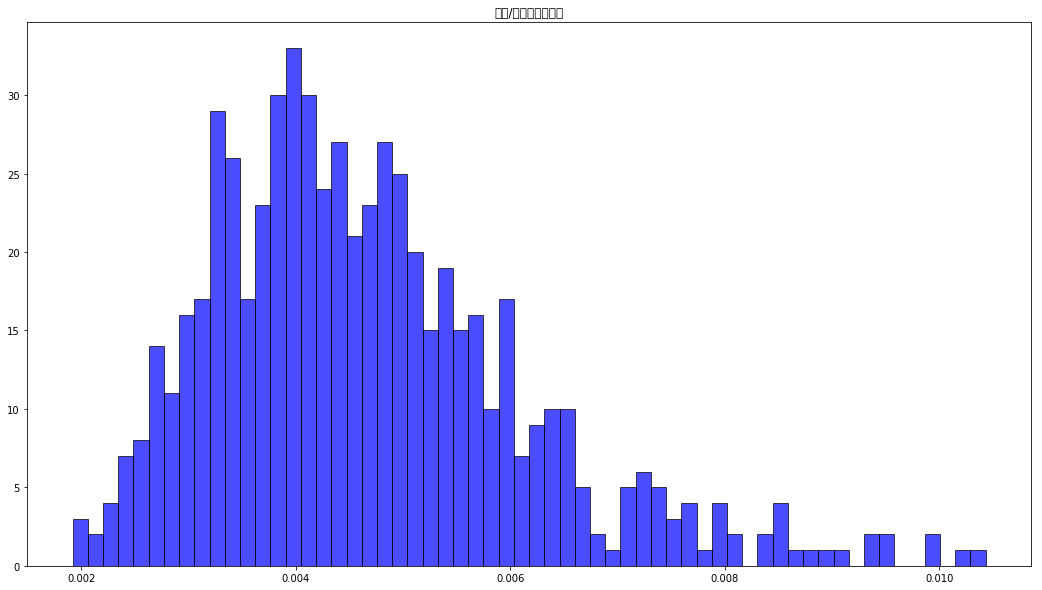

In [61]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.hist(np.array(test_scores)[itemindex_notis], bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [62]:
fm_fe = load('fm_fea')

print(np.array(fm_fe).shape)

fm_fe = np.array(fm_fe)

(211, 156)


In [63]:
fm_scores = []

for i in range(fm_fe.shape[0]):
    loss = autoencoder.evaluate(fm_fe[i:i+1], fm_fe[i:i+1], batch_size=1, verbose=0)
    fm_scores.append(loss)
    print('loss', loss)

loss 0.0034342785365879536
loss 0.0046722316183149815
loss 0.003113050013780594
loss 0.005226764362305403
loss 0.11532853543758392
loss 0.16330300271511078
loss 0.004105798900127411
loss 0.002957965712994337
loss 0.004738789517432451
loss 0.003420221386477351
loss 0.0051957471296191216
loss 0.004711605608463287
loss 0.005088264588266611
loss 0.008636952377855778
loss 0.031157976016402245
loss 0.0048259953036904335
loss 0.8459299802780151
loss 0.32033899426460266
loss 0.15364807844161987
loss 0.005249776877462864
loss 0.004759578965604305
loss 0.0028014983981847763
loss 0.0028513334691524506
loss 0.0036412763874977827
loss 0.002851082943379879
loss 0.007764987647533417
loss 0.013871140778064728
loss 0.003339578630402684
loss 0.007820519618690014
loss 0.07492724806070328
loss 0.0058059231378138065
loss 0.25639015436172485
loss 0.03274022787809372
loss 0.2352963238954544
loss 0.6319450736045837
loss 0.01236195769160986
loss 0.0046374499797821045
loss 0.1969781070947647
loss 0.998438894748

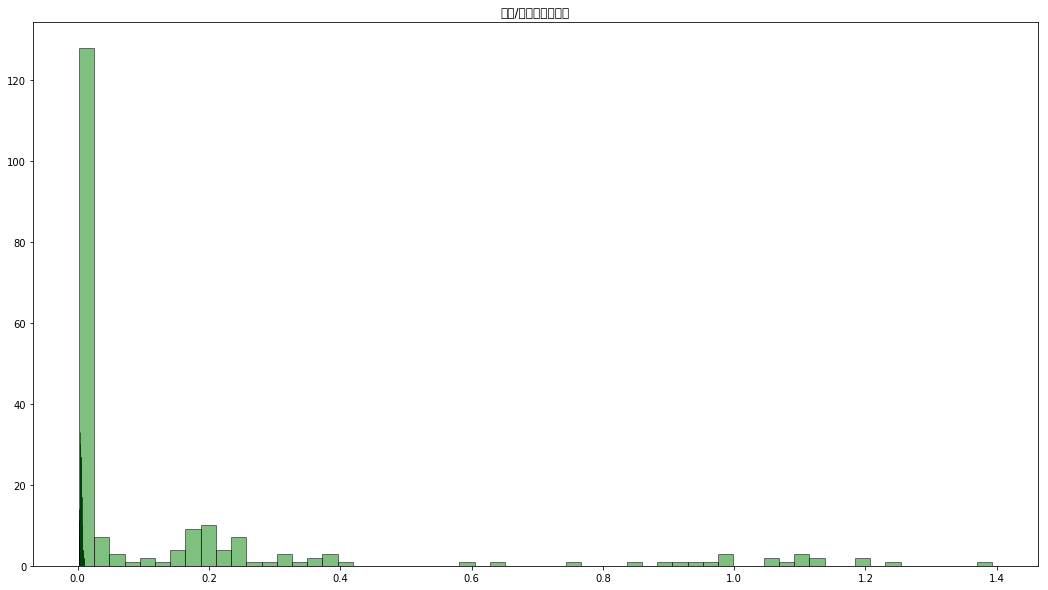

In [64]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.hist(np.array(noise_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)
plt.hist(np.array(fm_scores), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [65]:
tmp_fm_scores= np.array(fm_scores)

tmp_fm_scores_s=tmp_fm_scores[tmp_fm_scores<0.55]

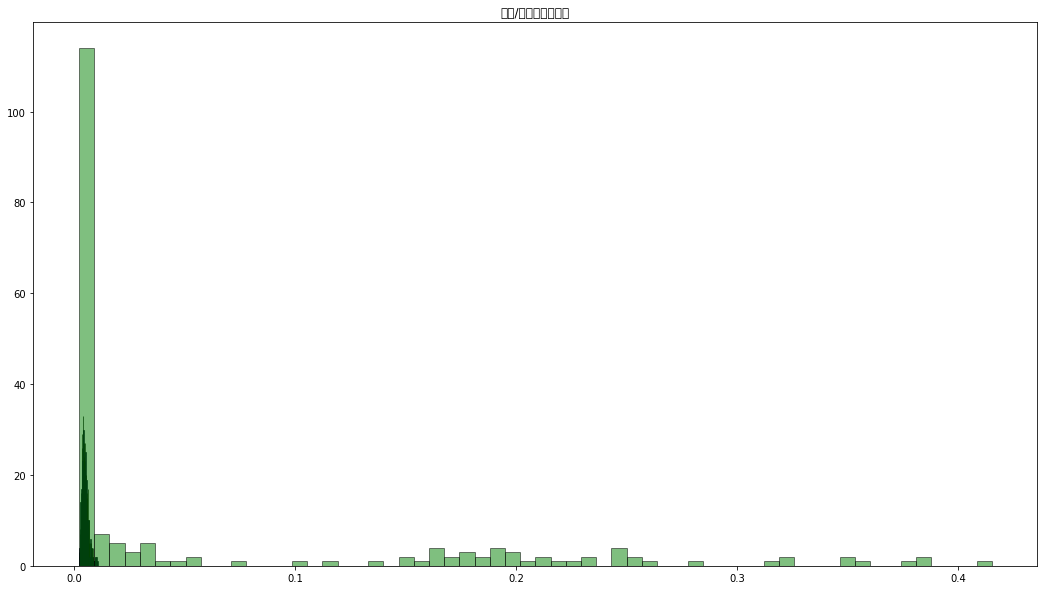

In [66]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# plt.hist(np.array(noise_scores), bins=60, normed=0, facecolor="red", edgecolor="black", alpha=0.7)
plt.hist(np.array(tmp_fm_scores_s), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()

In [67]:
from tqdm import tqdm

print("Extracting features ...")
tmps = []

tmps_fm_scores = []
file_name = {}

for i, (raw_file_name, joined_file_path) in tqdm(enumerate(collect_files('../feishouquan'))):
    _, sig = wav.read(joined_file_path)
    fea = extract(sig)
    feats = normalize_frames(np.array(fea))
    loss = autoencoder.evaluate(feats.reshape(1,-1), feats.reshape(1,-1), batch_size=1, verbose=0)
    tmps_fm_scores.append(loss)
    print("文件路径:{}, 文件名:{}, loss: {}".format(joined_file_path, raw_file_name, loss))
    file_name[raw_file_name]=loss
        
print("Done.")

1it [00:00,  8.53it/s]

Extracting features ...
文件路径:../feishouquan/93.7MHz.wav, 文件名:93.7MHz, loss: 0.013479077257215977


3it [00:00,  8.12it/s]

文件路径:../feishouquan/87.6MHz.wav, 文件名:87.6MHz, loss: 0.08072589337825775
文件路径:../feishouquan/94.1MHz.wav, 文件名:94.1MHz, loss: 0.03308891877532005


5it [00:00,  7.83it/s]

文件路径:../feishouquan/89.4MHz.wav, 文件名:89.4MHz, loss: 0.25195199251174927
文件路径:../feishouquan/87.7MHz.wav, 文件名:87.7MHz, loss: 0.019116347655653954


7it [00:00,  7.65it/s]

文件路径:../feishouquan/94.2MHz.wav, 文件名:94.2MHz, loss: 0.03430640324950218
文件路径:../feishouquan/102.5MHz.wav, 文件名:102.5MHz, loss: 0.004825294483453035
Done.


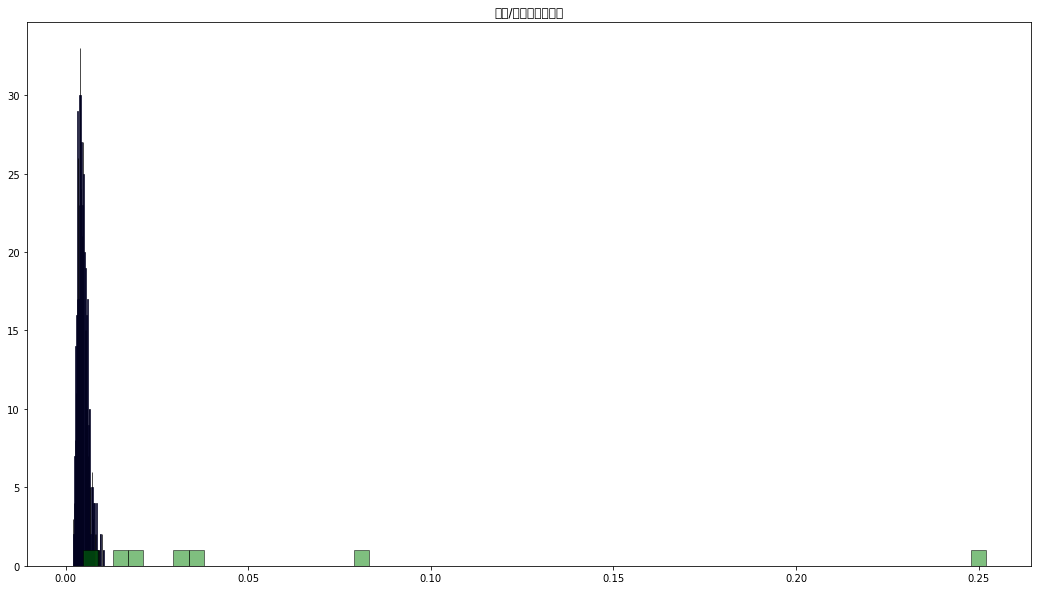

In [68]:
plt.figure(figsize=(18,10))
plt.hist(np.array(scores), bins=60, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
plt.hist(np.array(tmps_fm_scores), bins=60, normed=0, facecolor="green", edgecolor="black", alpha=0.5)

# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()